In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, EfficientFrontier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set plot styles
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
# Define the assets we'll analyze
assets = ['AAPL', 'AMZN', 'AGG']

# Define the time period
end_date = "2023-12-31"
start_date = "2015-01-01"


# Fetch the data
data = yf.download(assets, start=start_date, end=end_date)
print("\nData shape:", data.shape)

# Display basic information about the dataset
print("\nData columns:")
print(data.columns.levels[0].tolist())
print("\nFirst few rows of Adj Close prices:")
print(data['Close'].head())

# Extract just the Adjusted Close prices for simplicity
prices = data['Close'].copy()

# Check for missing values
print("\nMissing values in each column:")
print(prices.isna().sum())
# Fill any missing values using forward fill method
if prices.isna().sum().any():
    prices = prices.fillna(method='ffill')
    print("Missing values filled using forward fill")


[*********************100%***********************]  3 of 3 completed


Data shape: (2264, 15)

Data columns:
['Close', 'High', 'Low', 'Open', 'Volume']

First few rows of Adj Close prices:
Ticker           AAPL        AGG     AMZN
Date                                     
2015-01-02  24.320433  84.701523  15.4260
2015-01-05  23.635292  84.885567  15.1095
2015-01-06  23.637512  85.100349  14.7645
2015-01-07  23.968960  85.084991  14.9210
2015-01-08  24.889904  84.954575  15.0230

Missing values in each column:
Ticker
AAPL    0
AGG     0
AMZN    0
dtype: int64



Summary statistics of daily returns:
        annualized_return  annualized_volatility  sharpe_ratio
Ticker                                                        
AAPL             0.271994               0.290385      0.936664
AGG              0.014222               0.052935      0.268662
AMZN             0.309860               0.332671      0.931431


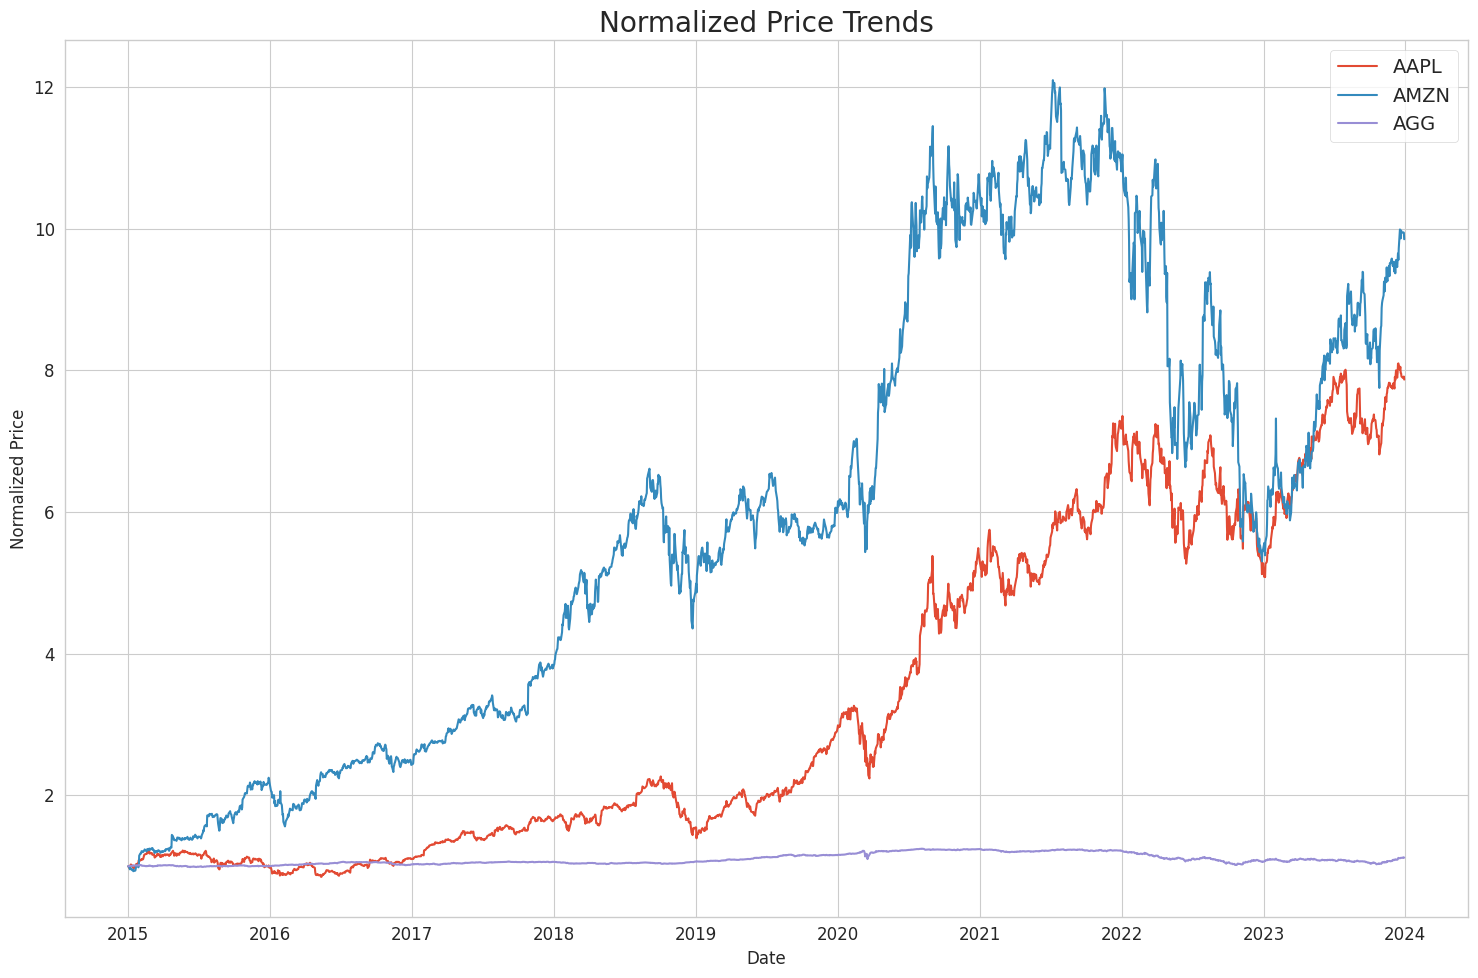

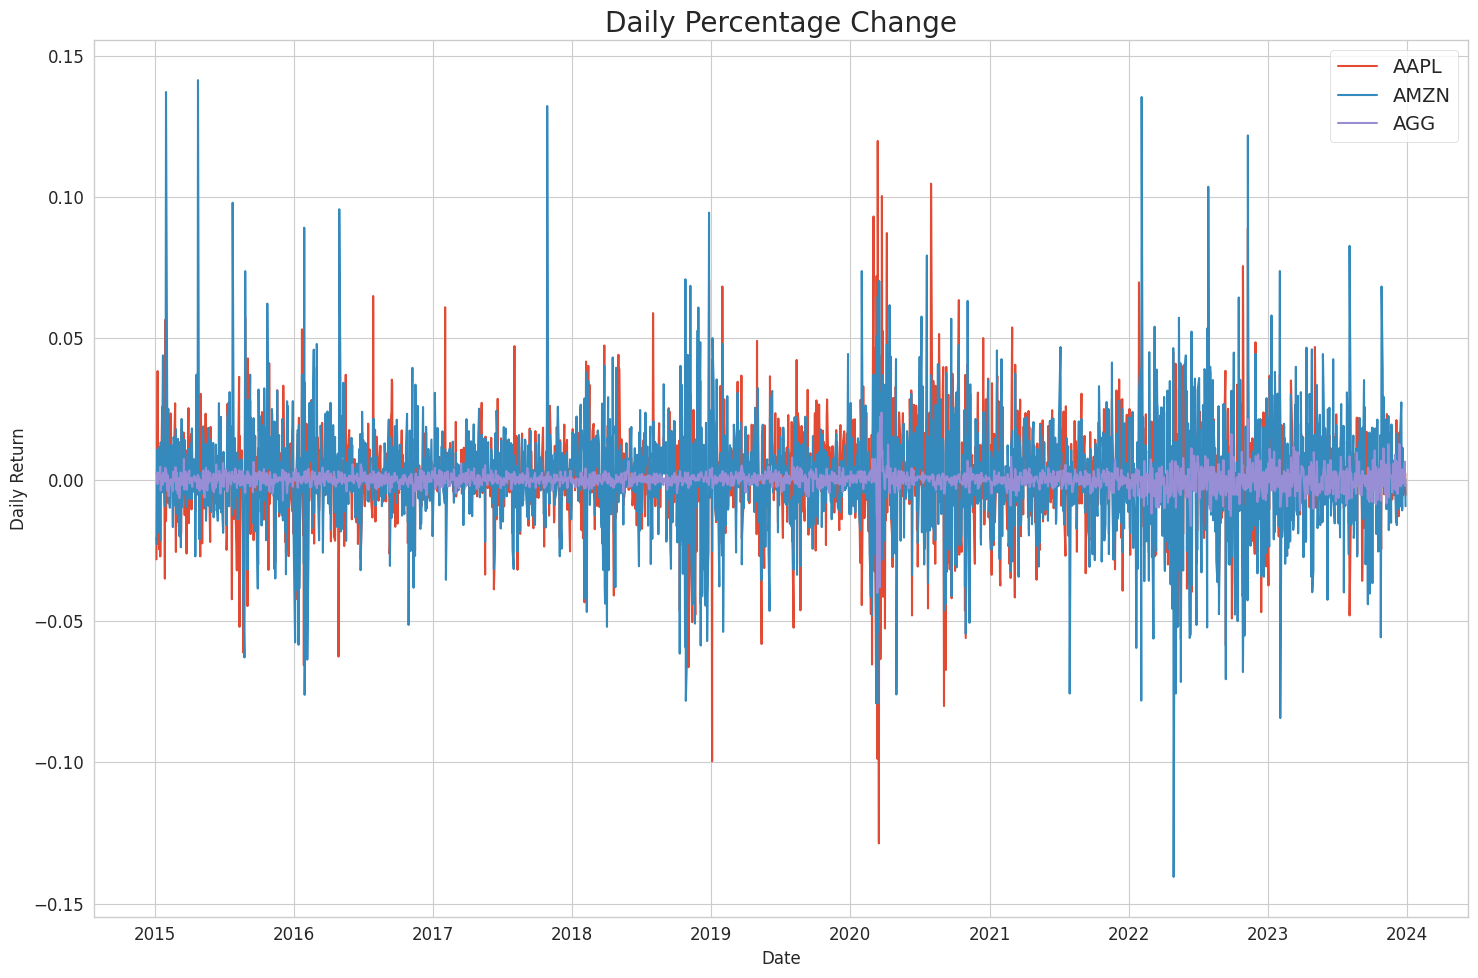

In [ ]:
# EXPLORATORY DATA ANALYSIS
# Calculate daily returns
returns = prices.pct_change().dropna()

# Plot the price trends
plt.figure(figsize=(15, 10))
for asset in assets:
    plt.plot(prices.index, prices[asset]/prices[asset].iloc[0], label=asset)
plt.title('Normalized Price Trends')
plt.ylabel('Normalized Price')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

# Plote teh change percentage
plt.figure(figsize=(15,10))
for ticker in assets:
    plt.plot(returns.index, returns[ticker], label=ticker)
plt.title("Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()


# Calculate and display key statistics
print("\nSummary statistics of daily returns:")
summary_stats = returns.describe().T
summary_stats['annualized_return'] = returns.mean() * 252
summary_stats['annualized_volatility'] = returns.std() * np.sqrt(252)
summary_stats['sharpe_ratio'] = summary_stats['annualized_return'] / summary_stats['annualized_volatility']
print(summary_stats[['annualized_return', 'annualized_volatility', 'sharpe_ratio']])



Testing stationarity of AAPL prices:
ADF Statistic: 0.2438
p-value: 0.9746
Critical Values:
	1%: -3.4333
	5%: -2.8628
	10%: -2.5675
Result: The series is non-stationary (fail to reject H0)

Testing stationarity of AAPL returns:
ADF Statistic: -14.8103
p-value: 0.0000
Critical Values:
	1%: -3.4333
	5%: -2.8628
	10%: -2.5675
Result: The series is stationary (reject H0)

Decomposing AAPL price series:

Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2036
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5203.764
Date:                Thu, 27 Feb 2025   AIC                         -10399.527
Time:                        07:09:23   BIC                         -10377.052
Sample:                             0   HQIC                        -10391.282
                               - 2036                                         
Covariance Type:    

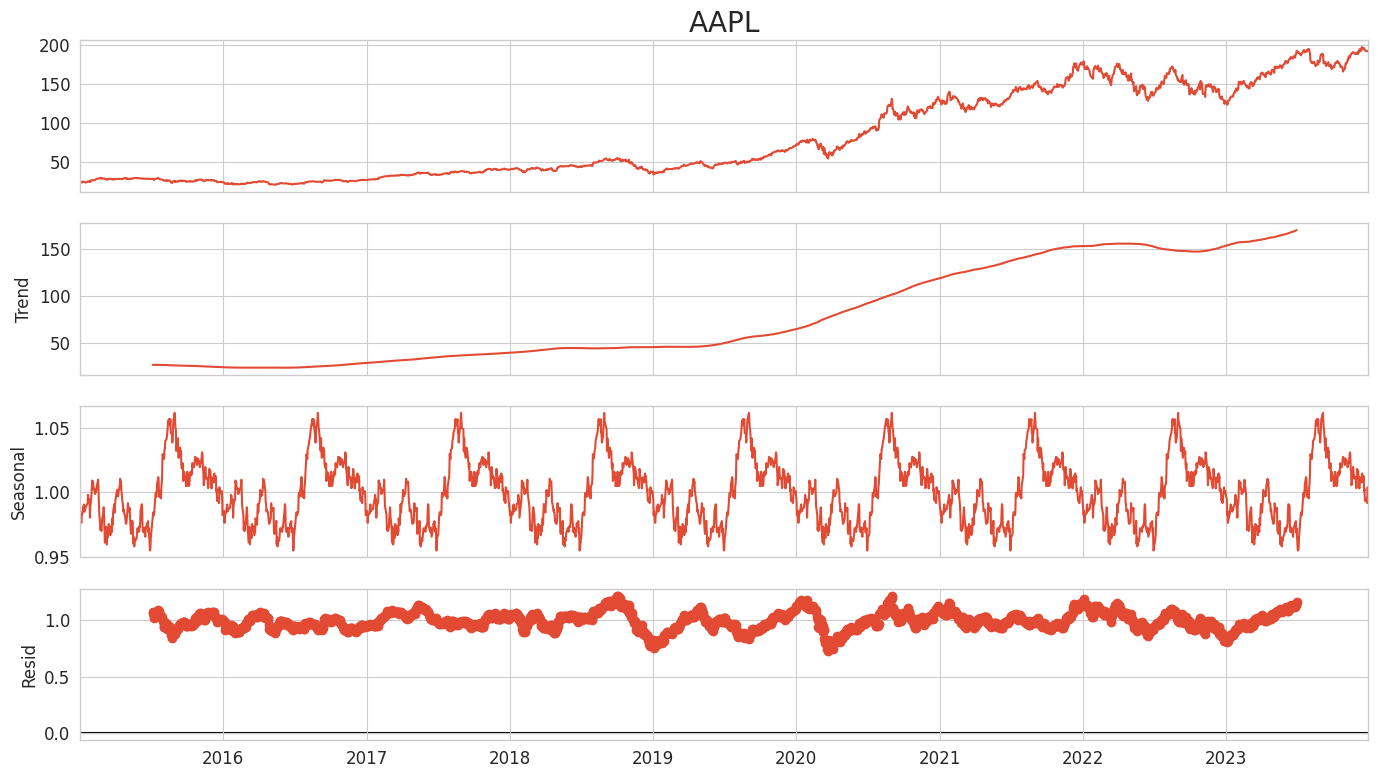

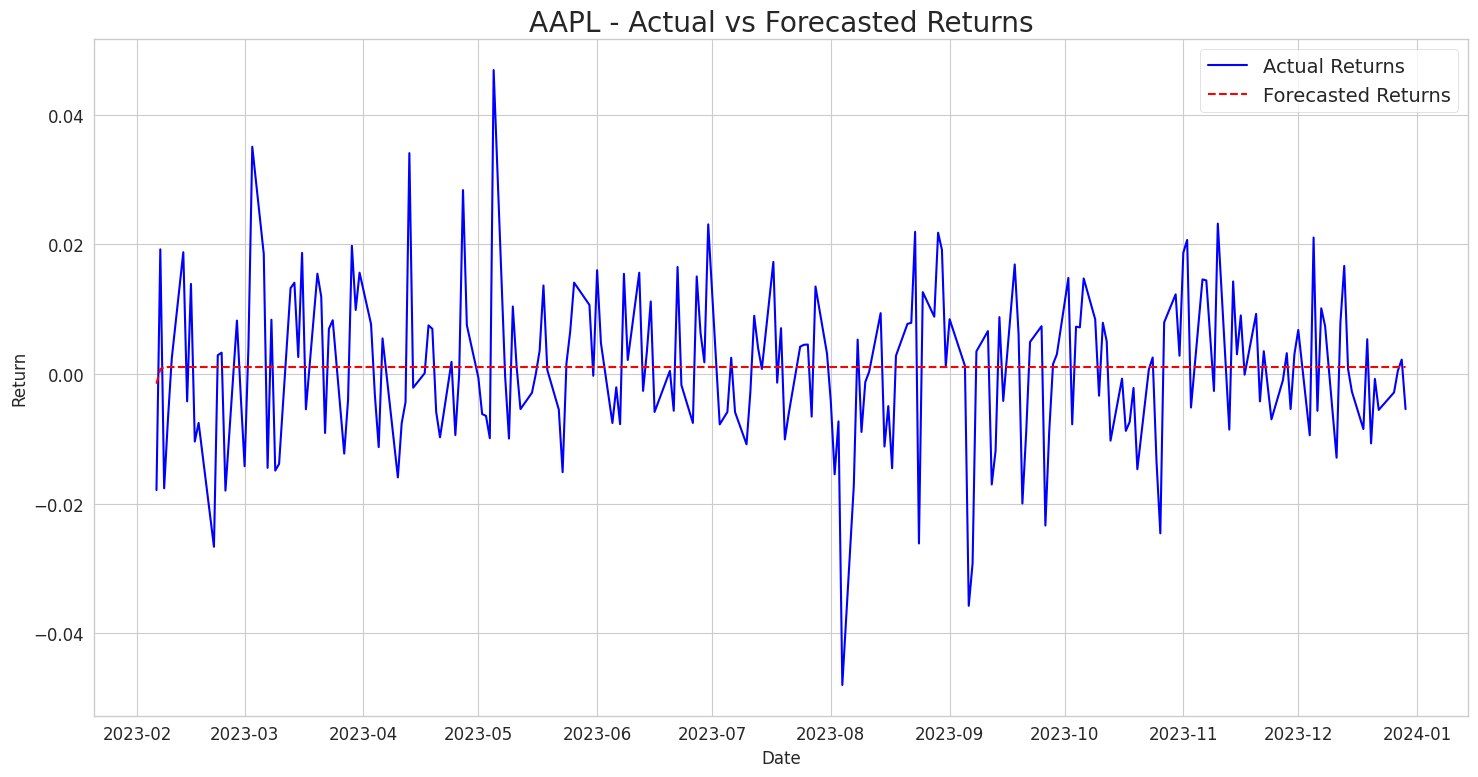

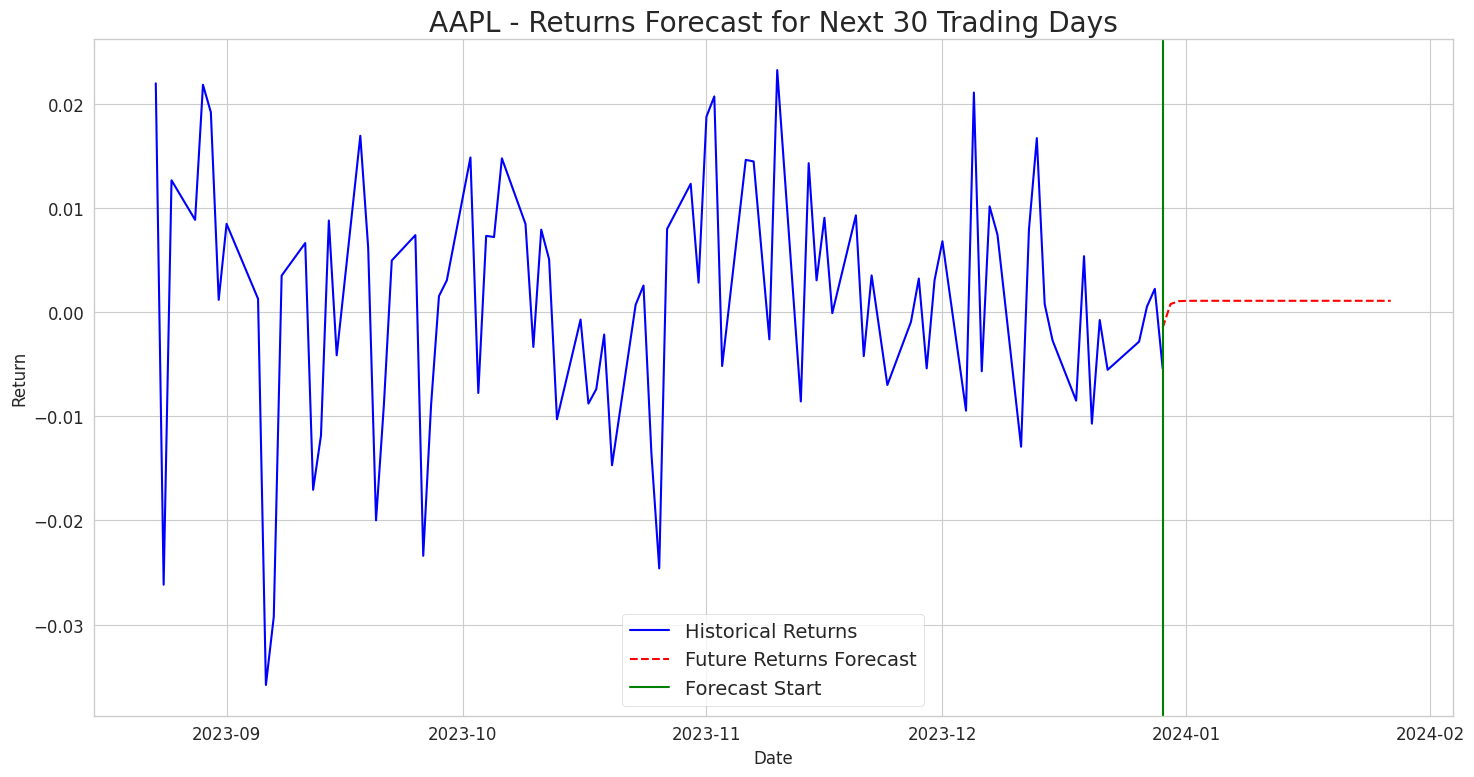

In [ ]:
# TIME SERIES ANALYSIS AND FORECASTING

# For the forecasting demo, we'll focus on just one asset (Apple)
forecast_asset = 'AAPL'
asset_price = prices[forecast_asset]
asset_returns = returns[forecast_asset]

# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is non-stationary (fail to reject H0)")

print(f"\nTesting stationarity of {forecast_asset} prices:")
check_stationarity(asset_price)

print(f"\nTesting stationarity of {forecast_asset} returns:")
check_stationarity(asset_returns)

# Time series decomposition
print(f"\nDecomposing {forecast_asset} price series:")
decomposition = seasonal_decompose(asset_price, model='multiplicative', period=252)  # 252 trading days in a year
fig = decomposition.plot()
plt.tight_layout()

# Fit an ARIMA model
print("\nFitting ARIMA model...")

# Prepare training data (use 90% for training)
train_size = int(len(asset_returns) * 0.9)
train_data = asset_returns.iloc[:train_size]
test_data = asset_returns.iloc[train_size:]

# Fit ARIMA model
p, d, q = 1, 0, 1  # Example parameters, would be determined by analysis in practice
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast and evaluate
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate error metrics
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"\nModel Evaluation on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Plot actual vs forecast returns
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='Actual Returns', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Returns', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Actual vs Forecasted Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()

# Generate and plot future forecasts
future_steps = 30  # Forecast 30 days ahead
future_forecast = model_fit.forecast(steps=future_steps)
future_dates = pd.date_range(start=asset_returns.index[-1], periods=future_steps)

plt.figure(figsize=(15, 8))
plt.plot(asset_returns.index[-90:], asset_returns.iloc[-90:], label='Historical Returns', color='blue')
plt.plot(future_dates, future_forecast, label='Future Returns Forecast', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Returns Forecast for Next {future_steps} Trading Days')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axvline(x=asset_returns.index[-1], color='green', linestyle='-', label='Forecast Start')
plt.legend()
plt.tight_layout()


In [ ]:
# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(data)  # Annualized returns
cov_matrix = risk_models.sample_cov(data)  # Annualized covariance

# Generate random portfolios
num_portfolios = 10000
assets = data.columns
n_assets = len(assets)

np.random.seed(42)
weights = np.random.dirichlet(np.ones(n_assets), num_portfolios)
returns = np.dot(weights, mu)
stddevs = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))
sharpe_ratios = returns / stddevs  # Assuming risk-free rate = 0

# Find min volatility and max Sharpe portfolios
min_vol_idx = np.argmin(stddevs)
max_sharpe_idx = np.argmax(sharpe_ratios)

# Random portfolios results
random_portfolios = [
    {'weights': w, 'return': r, 'stddev': s, 'sharpe': sr}
    for w, r, s, sr in zip(weights, returns, stddevs, sharpe_ratios)
]

# Use PyPortfolioOpt to get EXACT optimal portfolios

# Minimum Volatility Portfolio
ef_minvol = EfficientFrontier(mu, cov_matrix)
ef_minvol.min_volatility()
min_vol_weights = ef_minvol.clean_weights()
min_vol_return, min_vol_stddev, _ = ef_minvol.portfolio_performance()

# Maximum Sharpe Portfolio
ef_maxsharpe = EfficientFrontier(mu, cov_matrix)
ef_maxsharpe.max_sharpe()
max_sharpe_weights = ef_maxsharpe.clean_weights()
max_sharpe_return, max_sharpe_stddev, _ = ef_maxsharpe.portfolio_performance()

# Compile results into a dictionary
ef_results = {
    'random_portfolios': random_portfolios,
    'min_vol': {
        'weights': np.array([min_vol_weights[asset] for asset in assets]),
        'return': min_vol_return,
        'stddev': min_vol_stddev,
    },
    'max_sharpe': {
        'weights': np.array([max_sharpe_weights[asset] for asset in assets]),
        'return': max_sharpe_return,
        'stddev': max_sharpe_stddev,
    }
}


Minimum Volatility Portfolio:
Expected Return: 1.80%
Expected Volatility: 5.26%
Sharpe Ratio: 0.34
Asset Allocation:
AAPL: 2.09%
AGG: 97.91%
AMZN: 0.00%

Maximum Sharpe Ratio Portfolio:
Expected Return: 15.98%
Expected Volatility: 15.91%
Sharpe Ratio: 1.00
Asset Allocation:
AAPL: 31.67%
AGG: 43.36%
AMZN: 24.97%


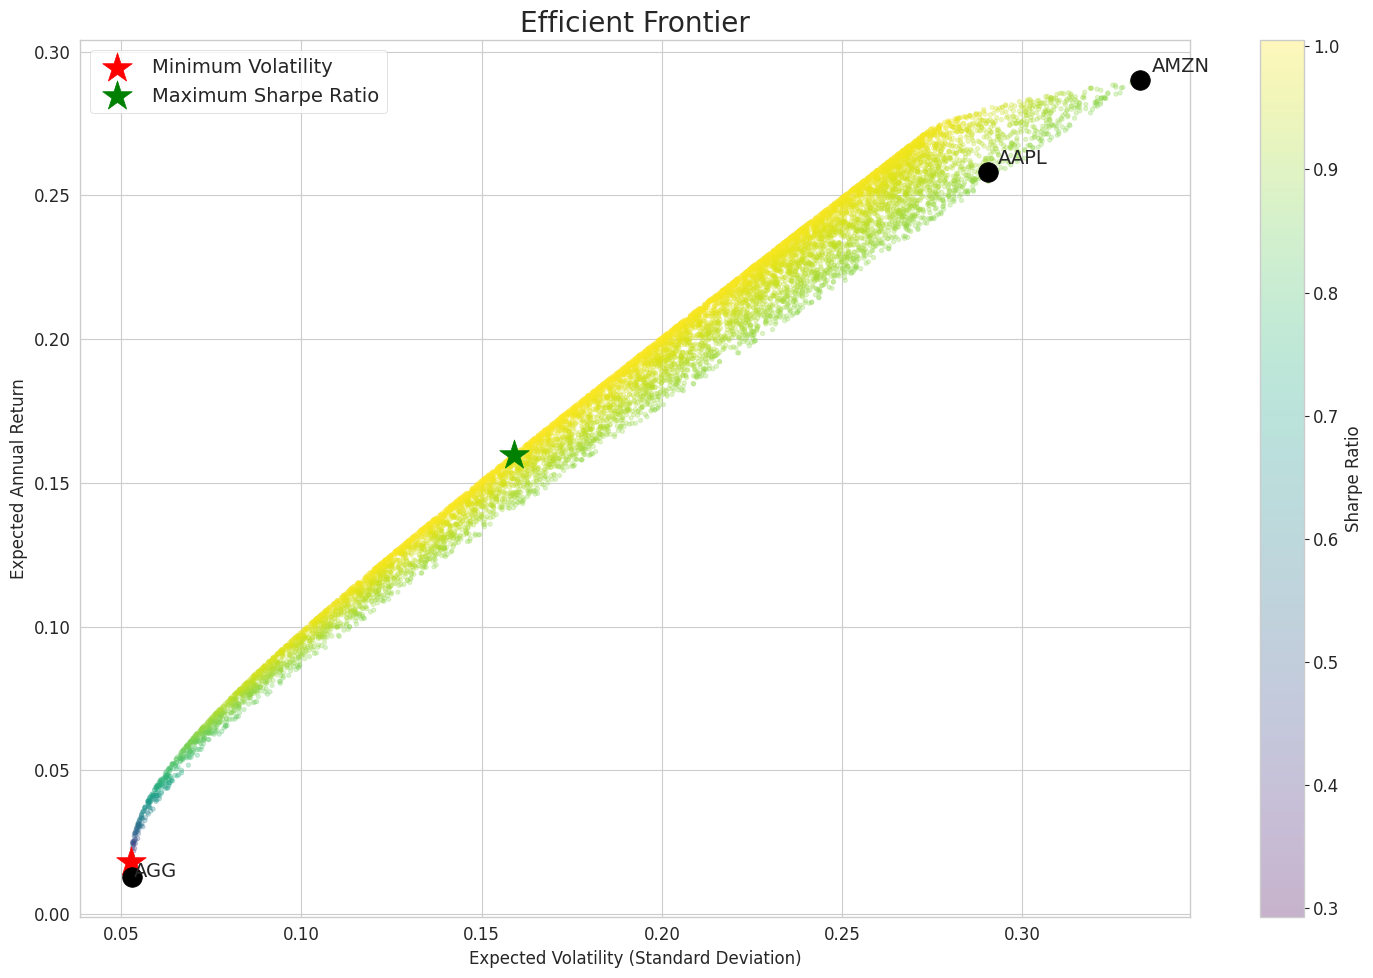

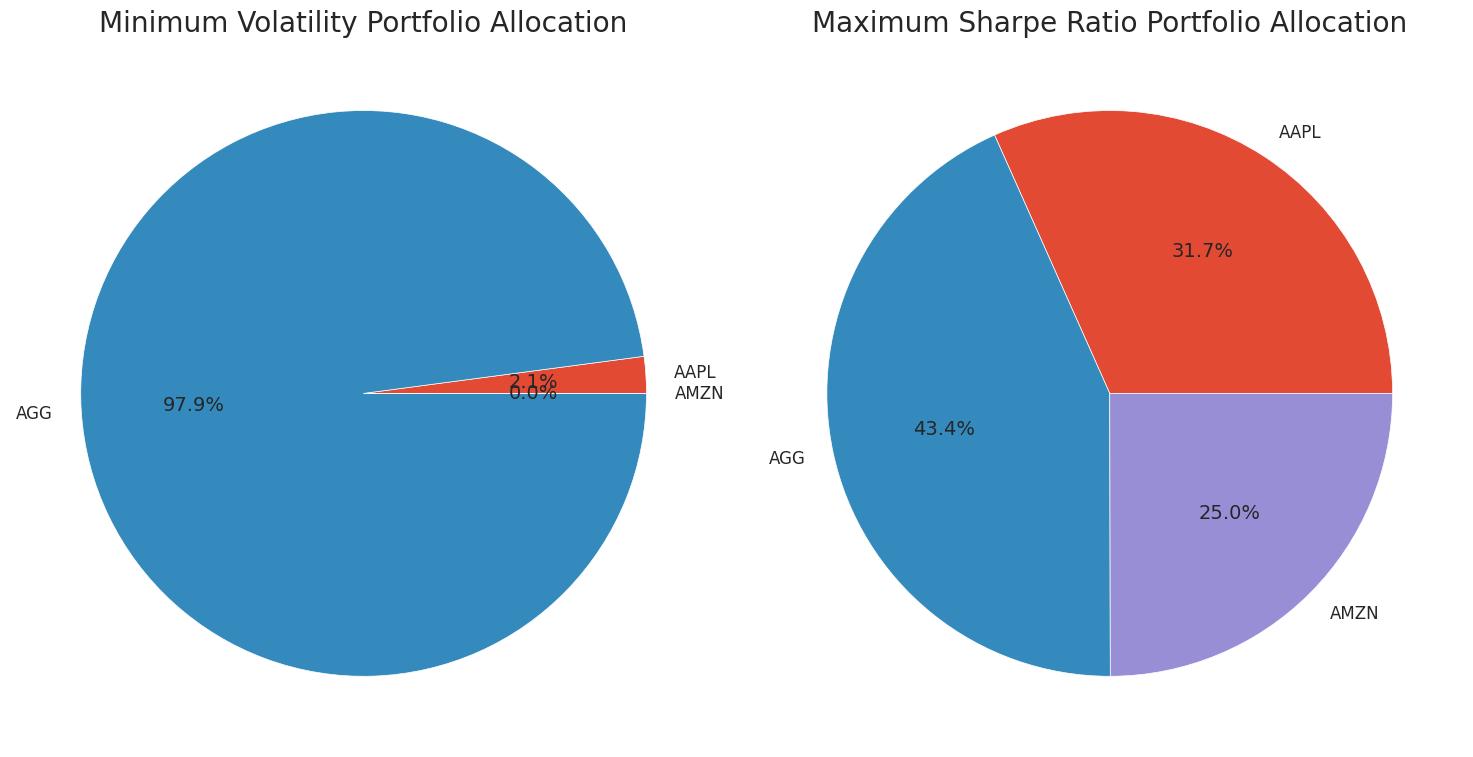

In [ ]:
# Plot Efficient Frontier
plt.figure(figsize=(15, 10))
returns = [p['return'] for p in ef_results['random_portfolios']]
stddevs = [p['stddev'] for p in ef_results['random_portfolios']]

plt.scatter(stddevs, returns, c=np.array(returns)/np.array(stddevs),
            marker='o', cmap='viridis', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Plot optimal portfolios
plt.scatter(ef_results['min_vol']['stddev'], ef_results['min_vol']['return'],
            marker='*', color='r', s=500, label='Minimum Volatility')
plt.scatter(ef_results['max_sharpe']['stddev'], ef_results['max_sharpe']['return'],
            marker='*', color='g', s=500, label='Maximum Sharpe Ratio')

# Plot individual assets
for i, asset in enumerate(assets):
    asset_vol = np.sqrt(cov_matrix.iloc[i, i])
    asset_ret = mu[i]
    plt.scatter(asset_vol, asset_ret, marker='o', s=200, color='black')
    plt.annotate(asset, (asset_vol*1.01, asset_ret*1.01))

plt.title('Efficient Frontier')
plt.xlabel('Expected Volatility (Standard Deviation)')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.tight_layout()

# Print Portfolio Weights & Metrics
print("\nMinimum Volatility Portfolio:")
print("Expected Return: {:.2%}".format(ef_results['min_vol']['return']))
print("Expected Volatility: {:.2%}".format(ef_results['min_vol']['stddev']))
print("Sharpe Ratio: {:.2f}".format(ef_results['min_vol']['return']/ef_results['min_vol']['stddev']))
print("Asset Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {ef_results['min_vol']['weights'][i]:.2%}")

print("\nMaximum Sharpe Ratio Portfolio:")
print("Expected Return: {:.2%}".format(ef_results['max_sharpe']['return']))
print("Expected Volatility: {:.2%}".format(ef_results['max_sharpe']['stddev']))
print("Sharpe Ratio: {:.2f}".format(ef_results['max_sharpe']['return']/ef_results['max_sharpe']['stddev']))
print("Asset Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {ef_results['max_sharpe']['weights'][i]:.2%}")

# Plot Asset Allocations
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.pie(ef_results['min_vol']['weights'], labels=assets, autopct='%1.1f%%')
plt.title('Minimum Volatility Portfolio Allocation')

plt.subplot(1, 2, 2)
plt.pie(ef_results['max_sharpe']['weights'], labels=assets, autopct='%1.1f%%')
plt.title('Maximum Sharpe Ratio Portfolio Allocation')

plt.tight_layout()
plt.show()

Optimized Portfolio Weights:
AAPL: 31.67%
AGG: 43.36%
AMZN: 24.97%


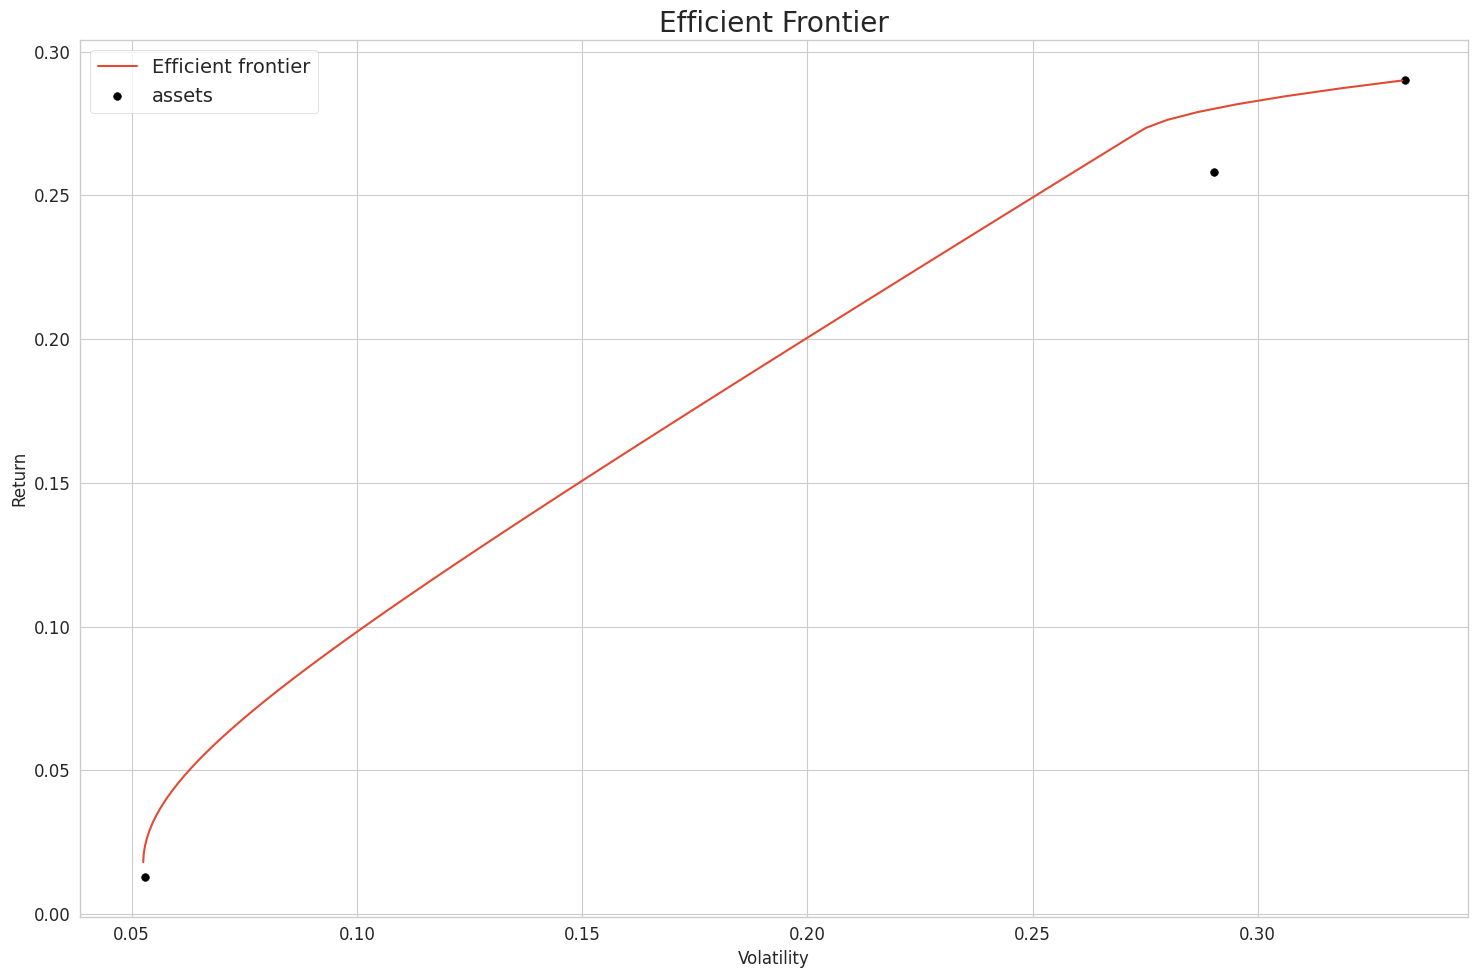

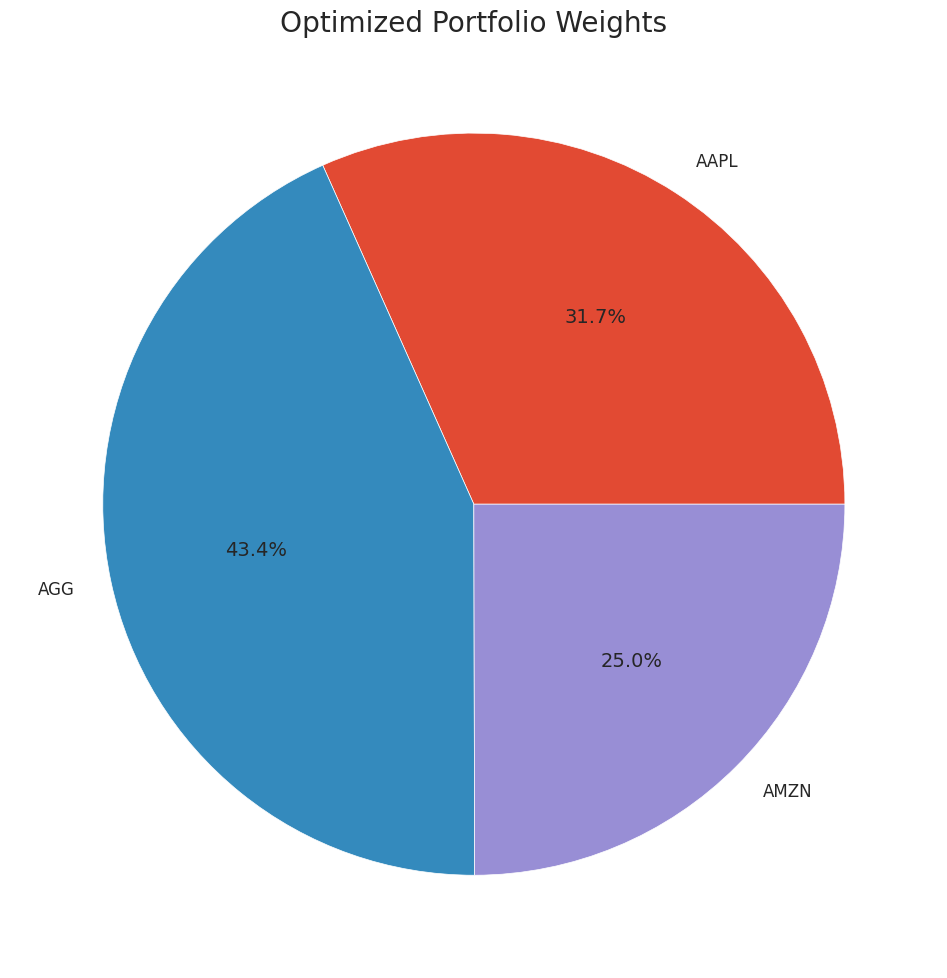

In [ ]:
# Portfolio Optimization

# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Optimize for max Sharpe Ratio
ef_opt = EfficientFrontier(mu, S)
weights = ef_opt.max_sharpe()
cleaned_weights = ef_opt.clean_weights()

# Print optimized weights
print("Optimized Portfolio Weights:")
for k, v in cleaned_weights.items():
    print(f"{k}: {100*v:.2f}%")

# Create a SECOND ef instance for plotting (do not optimize this one)
ef_plot = EfficientFrontier(mu, S)

# Plot Efficient Frontier
fig, ax = plt.subplots(figsize=(15, 10))
plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)
plt.title('Efficient Frontier')
plt.tight_layout()

# Plot asset allocation
plt.figure(figsize=(15, 10))
plt.pie(cleaned_weights.values(), labels=cleaned_weights.keys(), autopct='%1.1f%%')
plt.title('Optimized Portfolio Weights')
plt.tight_layout()

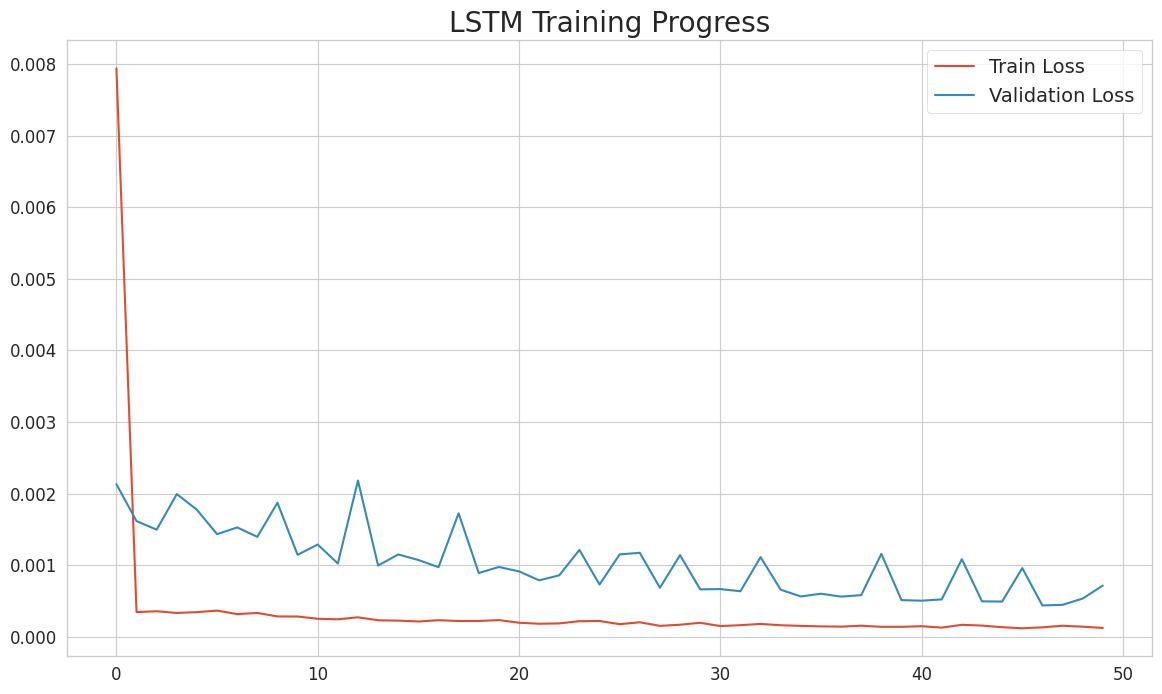

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step


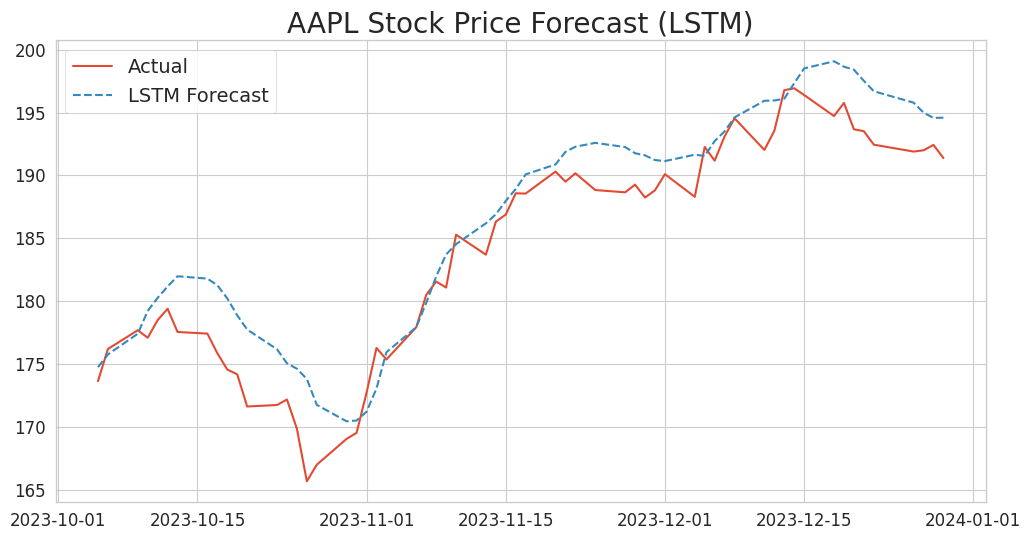

In [ ]:
# LSTM Forecasting (AAPL)
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
data = data['Close']
# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['AAPL'].values.reshape(-1,1))

# Create sequences
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                   validation_split=0.2, verbose=0)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Progress')
plt.legend()
plt.show()

# Predict
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast).flatten()

# Plot LSTM results
plt.figure(figsize=(12,6))
plt.plot(data['AAPL'].index[-60:], data['AAPL'][-60:], label='Actual')
plt.plot(data['AAPL'].index[-60:], lstm_forecast, label='LSTM Forecast', linestyle='--')
plt.title('AAPL Stock Price Forecast (LSTM)')
plt.legend()
plt.show()
